In [1]:
import numpy as np 

# Needleman-Wunsch Algorithm

In [4]:
#parse the BLOSUM50 matrix and store it in a dictionary for easy access
f = open("blosum50.txt", "r")
blosum50_text = f.read()
f.close()

blosum50_lines = blosum50_text.strip().split("\n")
amino_acids = blosum50_lines[0].split()

blosum50_matrix = {}

# Fill the dictionary with scores for each amino acid pair
for line in blosum50_lines[1:]:  
    scores = line.split()
    acid = scores[0]
    blosum50_matrix[acid] = {}
    for i, score in enumerate(scores[1:]):
        blosum50_matrix[acid][amino_acids[i+1]] = int(score)

#display(blosum50_matrix)

In [5]:

#Needleman-Wunsch

def needleman_wunsch(seq1, seq2, scoring_matrix, gap_penalty):

    #initialize the scoring matrix
    rows = len(seq1) + 1
    cols = len(seq2) + 1
    score_matrix = [[0] * cols for _ in range(rows)]
    
    for i in range(1, rows):
        score_matrix[i][0] = score_matrix[i-1][0] + gap_penalty
    
    for j in range(1, cols):
        score_matrix[0][j] = score_matrix[0][j-1] + gap_penalty
    
    #formula from slides
    for i in range(1, rows):
        for j in range(1, cols):
            match = score_matrix[i-1][j-1] + scoring_matrix[seq1[i-1]][seq2[j-1]]
            delete = score_matrix[i-1][j] + gap_penalty
            insert = score_matrix[i][j-1] + gap_penalty
            score_matrix[i][j] = max(match, delete, insert)
    
    #traceback 
    align1 = ""
    align2 = ""
    i, j = rows - 1, cols - 1

    while i > 0 and j > 0:
        score_current = score_matrix[i][j]
        score_diagonal = score_matrix[i-1][j-1]
        score_up = score_matrix[i][j-1]
        score_left = score_matrix[i-1][j]
        
        if score_current == score_diagonal + scoring_matrix[seq1[i-1]][seq2[j-1]]:
            align1 += seq1[i-1]
            align2 += seq2[j-1]
            i -= 1
            j -= 1
        elif score_current == score_left + gap_penalty:
            align1 += seq1[i-1]
            align2 += '-'
            i -= 1
        elif score_current == score_up + gap_penalty:
            align1 += '-'
            align2 += seq2[j-1]
            j -= 1

    #trace to top left
    while i > 0:
        align1 += seq1[i-1]
        align2 += '-'
        i -= 1
    while j > 0:
        align1 += '-'
        align2 += seq2[j-1]
        j -= 1

    return align1[::-1], align2[::-1]

aligned_seq1, aligned_seq2 = needleman_wunsch("HEAGAWGHEE", "PAWHEAE", blosum50_matrix, -8)
print("Aligned Sequence 1: ", aligned_seq1)
print("Aligned Sequence 2: ", aligned_seq2)


aligned_seq1, aligned_seq2 = needleman_wunsch("SALPQPTTPVSSFTSGSMLGRTDTALTNTYSAL", "PSPTMEAVTSVEASTASHPHSTSSYFATTYYHLY", blosum50_matrix, -8)
print("Aligned Sequence 1: ", aligned_seq1)
print("Aligned Sequence 2: ", aligned_seq2)



Aligned Sequence 1:  HEAGAWGHE-E
Aligned Sequence 2:  --P-AW-HEAE
Aligned Sequence 1:  -SALPQPTTPVSSFTSGSMLGRTDTALTNTYSAL-
Aligned Sequence 2:  PSPTMEAVTSVEA-STASHPHSTSSYFATTYYHLY


# Smith Waterman

In [6]:
def smith_waterman(seq1, seq2, scoring_matrix, gap_penalty):
   
    #initialize the scoring matrix
    rows = len(seq1) + 1
    cols = len(seq2) + 1
    score_matrix = [[0] * cols for _ in range(rows)]
    max_score = 0
    max_pos = (0, 0)

    #formula from slides
    for i in range(1, rows):
        for j in range(1, cols):
            match = score_matrix[i-1][j-1] + scoring_matrix[seq1[i-1]][seq2[j-1]]
            delete = score_matrix[i-1][j] + gap_penalty
            insert = score_matrix[i][j-1] + gap_penalty
            score = max(match, delete, insert, 0)
            score_matrix[i][j] = score
            
            if score > max_score:
                max_score = score
                max_pos = (i, j)

    #traceback
    align1, align2 = "", ""
    i, j = max_pos
    while score_matrix[i][j] > 0:
        score_current = score_matrix[i][j]
        score_diagonal = score_matrix[i-1][j-1]
        score_up = score_matrix[i][j-1]
        score_left = score_matrix[i-1][j]
        
        if score_current == score_diagonal + scoring_matrix[seq1[i-1]][seq2[j-1]]:
            align1 += seq1[i-1]
            align2 += seq2[j-1]
            i -= 1
            j -= 1
        elif score_current == score_left + gap_penalty:
            align1 += seq1[i-1]
            align2 += '-'
            i -= 1
        else:  
            align1 += '-'
            align2 += seq2[j-1]
            j -= 1

    return align1[::-1], align2[::-1]

aligned_seq1, aligned_seq2 = smith_waterman("HEAGAWGHEE", "PAWHEAE", blosum50_matrix, -8)
print("Aligned Sequence 1: ", aligned_seq1)
print("Aligned Sequence 2: ", aligned_seq2)

aligned_seq1, aligned_seq2 = smith_waterman("SALPQPTTPVSSFTSGSMLGRTDTALTNTYSAL", "PSPTMEAVTSVEASTASHPHSTSSYFATTYYHLY", blosum50_matrix, -8)
print("Aligned Sequence 1: ", aligned_seq1)
print("Aligned Sequence 2: ", aligned_seq2)

Aligned Sequence 1:  AWGHE
Aligned Sequence 2:  AW-HE
Aligned Sequence 1:  PQPT-TPVSSF-TS-GSMLGRTDTALTNTYSAL
Aligned Sequence 2:  PSPTMEAVTSVEASTASHPHSTSSYFATTYYHL


# HMM

In [7]:
import numpy as np

#HMM parameters
states = ['Fair', 'Loaded']
state_transition_probs = {
    'Fair': {'Fair': 0.9, 'Loaded': 0.1},
    'Loaded': {'Fair': 0.1, 'Loaded': 0.9}
}
emission_probs = {
    'Fair': [1/6]*6,
    'Loaded': [1/10]*5 + [1/2]
}

def simulate_dishonest_casino(num_rolls):
    
    current_state = 'Fair'
    rolls = []
    states_sequence = []

    for _ in range(num_rolls):
        
        roll = np.random.choice([1, 2, 3, 4, 5, 6], p=emission_probs[current_state])
        rolls.append(roll)
        states_sequence.append(current_state)
        
        current_state = np.random.choice(states, p=list(state_transition_probs[current_state].values()))

    return rolls, states_sequence

#100 rolls
rolls, states_sequence = simulate_dishonest_casino(100)

#format strings
rolls_str = ''.join(str(roll) for roll in rolls)
states_str = ''.join(f"{state[0]}" for state in states_sequence)

print( f"Rolls: {rolls_str}\nState: {states_str}\n")

#for roll, state in zip(rolls, states_sequence):
    #print(f"Roll: {roll}, State: {state}")





Rolls: 3242255412244666166466653666666624216656416621253661635544612623352626666666245666662435435266645324
State: FFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLFFLLLLLLLLLLFFFFLLLLLLLLLLLLLFFFFFLLLLLFLLLLLLLLLLLFFFFFFFLLLLFFFFF



In [9]:
## DNA HMM

#HMM parameters
states = ['AT Rich', 'CG Rich']
transition_probabilities = {
    'Start': {'AT': 0.5, 'CG': 0.5},
    'AT': {'AT': 0.9997, 'CG': 0.0003},
    'CG': {'AT': 0.0002, 'CG': 0.9998}
}
emission_probabilities = {
    'AT': {'A': 0.2698, 'T': 0.3297, 'C': 0.2080, 'G': 0.1985},
    'CG': {'A': 0.2459, 'T': 0.2079, 'C': 0.2478, 'G': 0.2984}
}

def generate_dna_sequence(length):
    import random
    
    current_state = 'Start'
    dna_sequence = ''

    for _ in range(length):
        if current_state != 'Start':
            dna_sequence += random.choices(
                population=list(emission_probabilities[current_state].keys()),
                weights=list(emission_probabilities[current_state].values())
            )[0]

        # Transition to the next state
        current_state = random.choices(
            population=list(transition_probabilities[current_state].keys()),
            weights=list(transition_probabilities[current_state].values())
        )[0]

    return dna_sequence

#80 chars per line
def display_sequence(sequence):
    line_length = 80
    for i in range(0, len(sequence), line_length):
        print(sequence[i:i+line_length])

# Generate a DNA sequence of length 2000 bases
dna_sequence = generate_dna_sequence(2001)

f = open("DNA-Sequence.txt", "w")
f.write(dna_sequence)
f.close()

print("DNA Sequence: ")
display_sequence(dna_sequence)

DNA Sequence: 
CCCAACGCCCTGACTACACCCCACACTTGCGTGTCTTAAATCCGCTAAGGGGGAAACGGGAATGGCCACGCTGTCCAAGA
CACGCATGATGTTCATATGAAGAAGAAAATCCCCGGCCCAATGCCCCAGAGCCTCAAAAAGGATCGAGTTAGCGACTGCC
GGGGCTCGTTGGGATCAGTCCGTGGTGACGAGTACATGCTGGGCGGTTATCAGCAAGGGGACTCGGTTCGGCTGACTAGA
GCTTTAGCATAATTGCAGAGGACATTTCGGCGCACATATTACGTAAAGGTAGATGCCCAAAGAAGAACTAGGCGCTCTTG
CTGCGTGGTGTGTTATGAGAAATACATCCATCGCGAGGGATGGGGAACGTCGCTTGCCCTGTAACTCCATAGGGGTCGAG
GCGCCACAAACCTTCCGGCCAACCGCGCGCGACTTACCTATGGATCTTAAGGCGTCGCCCTAGATCTCCAGACCGGGTCC
GGAGCCTTAGCACCGGGATTGAAGACATTTCCTATAGCCAAGCTAGGCATGCGCTCTAGCGTATACTTAGCTTGCCTAAG
ACCATAAGGCTTGCATACTTTATACTTGGGCGGAATCTTTCTCATTCGCGCTTTCCCGCATAGGCCCAACAATGTCCGTG
TAGGATTAAGGGACCGGCAAGTGTACACAACCCTACACAAGAGGCGGAGGGAGGTCGACCTGGGTAATGCTGAGATTGAA
AGATCCCGGGAGCATTGCCTCTGATTACAACGTTGTGTCGAAAGGCCGAGTGAACATAACGTCAATGCGATAGCCCGCTA
GGGGGGGACTCACTGAGTTACGGCAACCGCGAGGCGGCCAGTGTGGCTGGTTGTTGAACGGGGGAGGTTTACAGCCATGC
CTGAACCGGAAACGAAGCAGTAGACGAAGGGAAGACTTTTGCGGGCATCCGACTGACCAGGTGAGTAGGGGCCTTGATCG
CAATGGTGACGCT

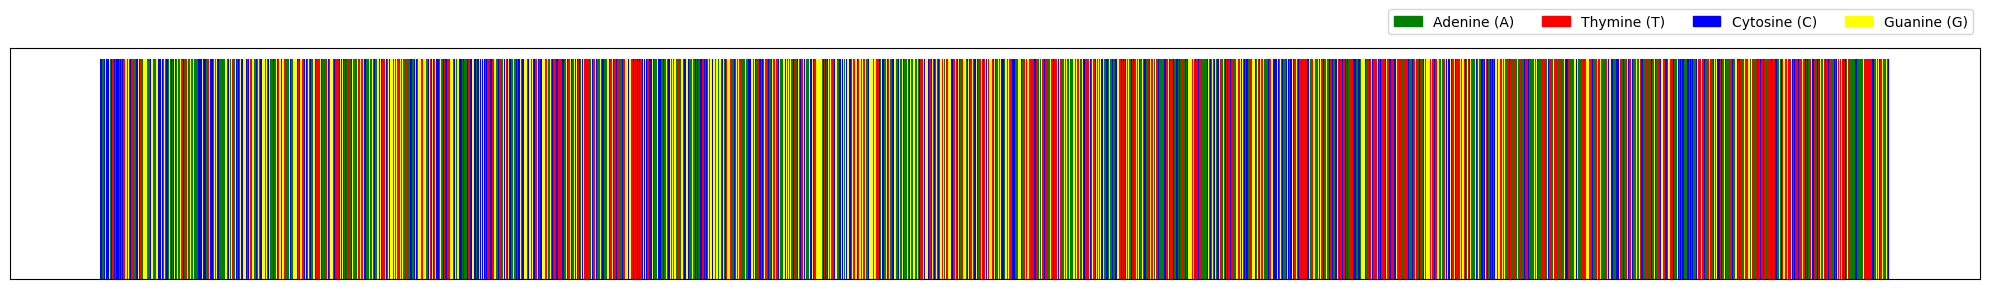

In [10]:
# Display DNA sequence

import matplotlib.pyplot as plt
import numpy as np

def plot_dna_sequence(sequence):

    colors = {'A': 'green', 'T': 'red', 'C': 'blue', 'G': 'yellow'}
    color_sequence = [colors[base] for base in sequence]
    
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.bar(np.arange(len(sequence)), np.ones(len(sequence)), color=color_sequence, width=1)
    
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    
    handles = [plt.Rectangle((0,0),1,1, color=colors[base]) for base in 'ATCG']
    labels = ['Adenine (A)', 'Thymine (T)', 'Cytosine (C)', 'Guanine (G)']
    ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1.2), ncol=4)

    plt.tight_layout()
    
    plt.savefig('dna_sequence_plot.png', dpi=300)

    plt.show()

plot_dna_sequence(dna_sequence) 

# Viterbi Algorithm

In [11]:
import math

def viterbi_log_space(observed_sequence, states, start_prob, trans_prob, emit_prob):

    V = [{}]
    path = {}
    log_zero = float('-inf')  #used to represent log(0)

    #starting probabilities and paths in log space
    for state in states:
        if start_prob[state] > 0:
            V[0][state] = math.log(start_prob[state]) + math.log(emit_prob[state][observed_sequence[0]])
        else:
            V[0][state] = log_zero
        path[state] = [state]

    #viterbi
    for t in range(1, len(observed_sequence)):
        V.append({})
        newpath = {}

        for current_state in states:
            max_prob = log_zero
            max_state = None
            for prev_state in states:
                if V[t-1][prev_state] != log_zero and trans_prob[prev_state][current_state] > 0:
                    prob = V[t-1][prev_state] + math.log(trans_prob[prev_state][current_state]) + math.log(emit_prob[current_state][observed_sequence[t]])
                    if prob > max_prob or max_state is None:
                        max_prob = prob
                        max_state = prev_state

            V[t][current_state] = max_prob
            newpath[current_state] = path[max_state] + [current_state]

        path = newpath

    #max probability 
    max_prob = log_zero
    max_state = None
    for state, prob in V[-1].items():
        if prob > max_prob or max_state is None:
            max_prob = prob
            max_state = state

    return (max_prob, path[max_state])




In [12]:
# HMM Parameters
states = ['F', 'L']
start_prob = {'F': 1.0, 'L': 0.0}
trans_prob = {
    'F': {'F': 0.9, 'L': 0.1},
    'L': {'F': 0.1, 'L': 0.9}
}
emit_prob = {
    'F': {'1': 1/6, '2': 1/6, '3': 1/6, '4': 1/6, '5': 1/6, '6': 1/6},
    'L': {'1': 0.1, '2': 0.1, '3': 0.1, '4': 0.1, '5': 0.1, '6': 0.5}
}

#dice roll sequence
observed_sequence = rolls_str

#viterbi
prob, path = viterbi_log_space(observed_sequence, states, start_prob, trans_prob, emit_prob)

print("Probability of the Viterbi path:",prob)
print("Viterbi path:", ''.join(path))

Probability of the Viterbi path: -169.11106574249214
Viterbi path: FFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFF


In [13]:
# DNA Viterbi

#HMM Parameters
states =  ['A', 'C']
start_prob = {'A': 0.5, 'C': 0.5}
trans_prob = {
    'A': {'A': 0.9997, 'C': 0.0003},
    'C': {'A': 0.0002, 'C': 0.9998}
}
emit_prob = {
    'A': {'A': 0.2698, 'T': 0.3297, 'C': 0.2080, 'G': 0.1985},
    'C': {'A': 0.2459, 'T': 0.2079, 'C': 0.2478, 'G': 0.2984}
}

#DNA sequence
f = open("DNA-Sequence.txt", "r")
observed_sequence = f.read()
f.close()

#viterbi
prob, path = viterbi_log_space(observed_sequence, states, start_prob, trans_prob, emit_prob)

path = ''.join(path)
path = '\n'.join(path[i:i+80] for i in range(0, len(path), 80))

print("Log probability of the Viterbi path:", prob)
print("Viterbi path (A = AT Rich, C = CG Rich):")
print(path)

Log probability of the Viterbi path: -2743.3265646654268
Viterbi path (A = AT Rich, C = CG Rich):
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCC

(FOR ABOVE 2) Both probabilities are low, the longer the sequence the lower the probability gets, nearing 0. Therefore, log probabilities are used.
States tend to hold for prolonged time as the probability of switching is much lower

In [14]:
## Lambda Phage Viterbi

#HMM Parameters
states =  ['A', 'C']
start_prob = {'A': 0.5, 'C': 0.5}
trans_prob = {
    'A': {'A': 0.9997, 'C': 0.0003},
    'C': {'A': 0.0002, 'C': 0.9998}
}
emit_prob = {
    'A': {'A': 0.2698, 'T': 0.3297, 'C': 0.2080, 'G': 0.1985},
    'C': {'A': 0.2459, 'T': 0.2079, 'C': 0.2478, 'G': 0.2984}
}

#lambda phage sequence
f = open("enteriobacteriophage.txt", "r")
phage_observed_sequence = f.read().replace("\n","")
f.close()

#viterbi 
prob, path = viterbi_log_space(phage_observed_sequence, states, start_prob, trans_prob, emit_prob)

path = ''.join(path)
path = '\n'.join(path[i:i+80] for i in range(0, len(path), 80))

print("Log probability of the Viterbi path:", prob)
print("Viterbi path (A = AT Rich, C = CG Rich):")
print(path)

Log probability of the Viterbi path: -66604.62685738035
Viterbi path (A = AT Rich, C = CG Rich):
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAACCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCC

# Posterior Probability

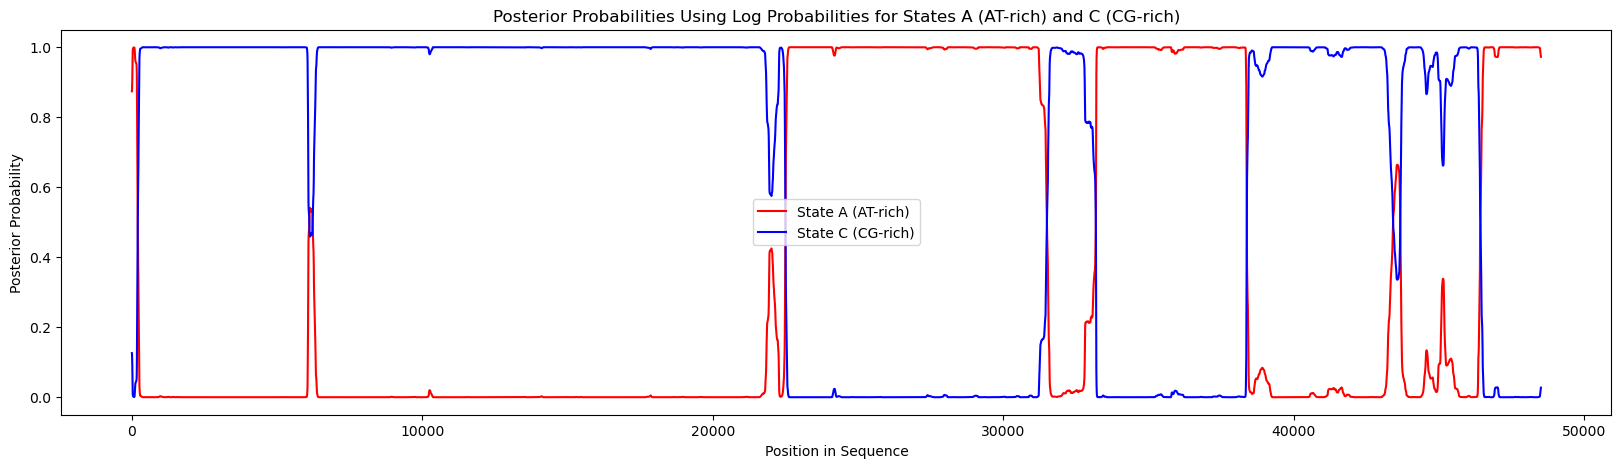

[{'A': 0.8738859409906999, 'C': 0.1261140590045715},
 {'A': 0.8741236299394294, 'C': 0.12587637005783664},
 {'A': 0.8745021541012685, 'C': 0.12549784589937088},
 {'A': 0.875085322465961, 'C': 0.12491467752688751},
 {'A': 0.8757841347320027, 'C': 0.12421586526419082},
 {'A': 0.8768425906806837, 'C': 0.12315740932406401},
 {'A': 0.8784391175210142, 'C': 0.12156088248098687},
 {'A': 0.8803428338502115, 'C': 0.11965716614321523},
 {'A': 0.8832078223448183, 'C': 0.1167921776489392},
 {'A': 0.8858189666684825, 'C': 0.11418103333299066},
 {'A': 0.8889309742268612, 'C': 0.11106902577205596},
 {'A': 0.8926395959422867, 'C': 0.10736040405636953},
 {'A': 0.8949769834910354, 'C': 0.10502301650505996},
 {'A': 0.8977628528480229, 'C': 0.10223714714640322},
 {'A': 0.9019529745767338, 'C': 0.09804702541880751},
 {'A': 0.9069459111164446, 'C': 0.09305408888658903},
 {'A': 0.9144533890942764, 'C': 0.0855466109070393},
 {'A': 0.9257409675416018, 'C': 0.0742590324593846},
 {'A': 0.9427114288179683, 'C': 0

In [15]:
##Posterior Probability


observation_sequence = phage_observed_sequence

#convert HMM probabilities to Log probabilities
states = ['A', 'C']
start_log_prob = {k: math.log(v) for k, v in start_prob.items()}
trans_log_prob = {k: {k2: math.log(v2) for k2, v2 in v.items()} for k, v in trans_prob.items()}
emit_log_prob = {k: {k2: math.log(v2) for k2, v2 in v.items()} for k, v in emit_prob.items()}

#initialise forward and backward matrices
log_F = [{s: float('-inf') for s in states} for _ in range(len(observation_sequence))]
log_B = [{s: float('-inf') for s in states} for _ in range(len(observation_sequence))]

#logarithm of sum for log probabilities (Log-Sum-Exp trick)
def log_sum_exp(a, b):
    return max(a, b) + math.log1p(math.exp(-abs(a - b)))

#first values for F and B
for s in states:
    log_F[0][s] = start_log_prob[s] + emit_log_prob[s][observation_sequence[0]]
    log_B[-1][s] = 0  # log(1) = 0

#forward
for i in range(1, len(observation_sequence)):
    for s in states:
        log_F[i][s] = log_sum_exp(
            log_F[i-1]['A'] + trans_log_prob['A'][s],
            log_F[i-1]['C'] + trans_log_prob['C'][s]
        ) + emit_log_prob[s][observation_sequence[i]]

#backwward
for i in range(len(observation_sequence) - 2, -1, -1):
    for s in states:
        log_B[i][s] = log_sum_exp(
            log_B[i+1]['A'] + trans_log_prob[s]['A'] + emit_log_prob['A'][observation_sequence[i+1]],
            log_B[i+1]['C'] + trans_log_prob[s]['C'] + emit_log_prob['C'][observation_sequence[i+1]]
        )


#calculate posterior probabilities
log_posterior_probs = [{s: float('-inf') for s in states} for _ in range(len(observation_sequence))]
for i in range(len(observation_sequence)):
    log_norm_factor = log_sum_exp(
        log_F[i]['A'] + log_B[i]['A'],
        log_F[i]['C'] + log_B[i]['C']
    )
    for s in states:
        log_posterior_probs[i][s] = log_F[i][s] + log_B[i][s] - log_norm_factor


#plot probabilities
plt.figure(figsize=(20, 5))

#convert back to regular 
prob_A_log = [math.exp(prob['A']) for prob in log_posterior_probs]
prob_C_log = [math.exp(prob['C']) for prob in log_posterior_probs]

plt.plot(prob_A_log, label='State A (AT-rich)', color='red')
plt.plot(prob_C_log, label='State C (CG-rich)', color='blue')
plt.xlabel('Position in Sequence')
plt.ylabel('Posterior Probability')
plt.title('Posterior Probabilities Using Log Probabilities for States A (AT-rich) and C (CG-rich)')
plt.legend()
plt.show()

#display regular probilities for first 100
posterior_probs = [{s: math.exp(log_posterior_probs[i][s]) for s in states} for i in range(100)]
display(posterior_probs)
